# Drone Object Detection with PyTorch
-------------------------------------
This notebook demonstrates how to use PyTorch to train a Faster R-CNN object detection model on the VisDrone dataset. The workflow covers data preparation, annotation handling, model selection, training, and evaluation.


# 1. Setup & Installation
All the required libraries should be installed in Colab by default.

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# 2. Data Collection
The VisDrone dataset is a large-scale benchmark for drone vision tasks, including object detection, tracking, and classification.

For object detection, the dataset includes 10 object categories, such as pedestrians, vehicles, bicycles, and tricycles, with annotations provided as bounding box coordinates (x, y, width, height). Additional attributes like truncation (visibility level) and occlusion (obstruction level) are also included.

In [ ]:
# Download the VisDrone dataset
!gdown 1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn
!gdown 1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59

Downloading...
From (original): https://drive.google.com/uc?id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn
From (redirected): https://drive.google.com/uc?id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn&confirm=t&uuid=2564530a-09d8-4032-9015-6c0460cef674
To: /content/VisDrone2019-DET-train.zip
100% 1.55G/1.55G [00:53<00:00, 28.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59
From (redirected): https://drive.google.com/uc?id=1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59&confirm=t&uuid=650e5377-de0c-4b9a-bd07-117a6df7165e
To: /content/VisDrone2019-DET-val.zip
100% 81.6M/81.6M [00:01<00:00, 64.3MB/s]


In [ ]:
# Unzip the datasets
!unzip -q /content/VisDrone2019-DET-train.zip -d /content/VisDrone2019
!unzip -q /content/VisDrone2019-DET-val.zip -d /content/VisDrone2019

replace /content/VisDrone2019/VisDrone2019-DET-train/annotations/0000002_00005_d_0000014.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/VisDrone2019/VisDrone2019-DET-val/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# 3. Data Annotation & Preprocessing
VisDrone annotations are provided in a text file for each image.

Each line contains: \<target_id>, \<x>, \<y>, \<width>, \<height>, \<score>, \<object_category>, \<truncation>, \<occlusion>.

For training we will use \<x>, \<y>, \<width>, \<height>, and \<object_category>. We will also remap some of the object categories so that we are only detecting two classes; humans and vehicles.

We also check for invalid bounding box dimensions as there are a few examples in this dataset.

In [ ]:
class VisDroneDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None, img_size=(800, 600)):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.img_size = img_size  # Image size (width, height)
        self.image_files = sorted(os.listdir(images_dir))
        self.annotation_files = sorted(os.listdir(annotations_dir))

        # Define mapping: class -> human (0) or vehicle (1)
        self.category_mapping = {
            4: 0,  # pedestrian -> human
            5: 0,  # people -> human
            1: 1,  # bicycle -> vehicle
            2: 1,  # car -> vehicle
            3: 1,  # van -> vehicle
            6: 1,  # truck -> vehicle
            7: 1,  # tricycle -> vehicle
            8: 1,  # awning-tricycle -> vehicle
            9: 1,  # bus -> vehicle
            10: 1, # motor -> vehicle
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape

        # Load annotations
        ann_path = os.path.join(self.annotations_dir, self.annotation_files[idx])
        boxes = []
        labels = []
        with open(ann_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                x, y, w, h, original_label = map(int, parts[0:5])

                # Ignore class 0 ("ignored regions")
                if original_label == 0:
                    continue

                # Remap the label
                if original_label in self.category_mapping:
                    new_label = self.category_mapping[original_label]

                    # Check if the bounding box has valid dimensions
                    if w <= 0 or h <= 0:  # Invalid if width or height is 0 or negative
                        continue

                    # Ensure the bounding box is within the image boundaries
                    x1, y1, x2, y2 = x, y, x + w, y + h
                    if x2 > width or y2 > height:  # Bounding box exceeds image dimensions
                        continue

                    boxes.append([x, y, x + w, y + h])
                    labels.append(new_label)

        # Convert boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create target dictionary
        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

# 4. Model Selection
We use Faster R-CNN with a ResNet-50 backbone pre-trained on COCO. This allows us to leverage transfer learning and adapt the model to VisDrone data.

Faster-RCNN is chosen as it provides a good trade-off between performance and accuracy, and performs well with small objects, making it ideal for precise detection of humans and vehicles in aerial footage.

In [ ]:
# Load the pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one for two classes (human, vehicle)
num_classes = 2  # 2 object categories (human and vehicle)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# 5. Training

In [ ]:
# Define data transformations
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

# Prepare the dataset and data loaders
train_dataset = VisDroneDataset(
    images_dir='/content/VisDrone2019/VisDrone2019-DET-train/images',
    annotations_dir='/content/VisDrone2019/VisDrone2019-DET-train/annotations',
    transforms=get_transform()
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

  0%|          | 0/1618 [00:00<?, ?it/s]

Epoch [1/1], Loss: 1630.7374


# 6. Evaluation

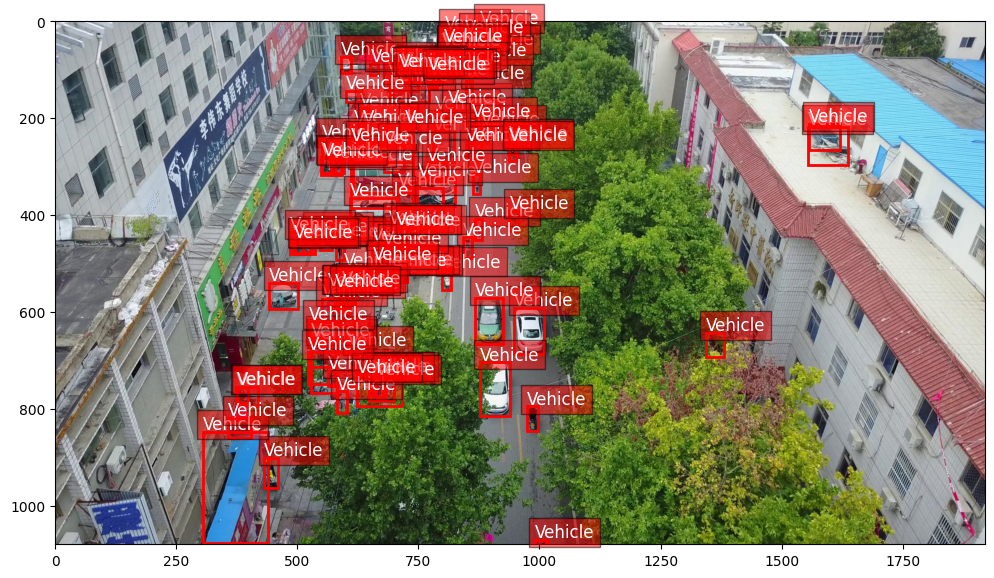

In [ ]:
val_dataset = VisDroneDataset(
    images_dir='/content/VisDrone2019/VisDrone2019-DET-val/images',
    annotations_dir='/content/VisDrone2019/VisDrone2019-DET-val/annotations',
    transforms=get_transform()
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Switch model to evaluation mode
model.eval()

# Evaluate and visualize predictions
def visualize_prediction(image, prediction):
    img = image.permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    for box, label in zip(prediction['boxes'].cpu(), prediction['labels'].cpu()):
        x1, y1, x2, y2 = box.int()
        label_name = "Human" if label == 0 else "Vehicle"
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
        plt.text(x1, y1 - 5, label_name, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

# Test on a single image
images, targets = next(iter(val_loader))
images = list(img.to(device) for img in images)
with torch.no_grad():
    predictions = model(images)
visualize_prediction(images[0].cpu(), predictions[0])

# Optional Exercises

1. **Perform Validation at the End of Each Epoch**  
   Modify the training loop to include a validation step at the end of each epoch. Plot the training and validation loss curves for each epoch. If validation metrics (e.g., mAP or classification accuracy) are computed, include them as well to analyze overfitting or underfitting.

2. **Experiment with Different Backbones**  
   Replace the default ResNet-50 backbone of Faster R-CNN with other pre-trained backbones, such as ResNet-101 or MobileNet-v3, and compare their performance and training speed.

3. **Hyperparameter Tuning**  
   Experiment with different hyperparameters, such as the learning rate, optimizer (e.g., SGD vs. AdamW), batch size, and number of epochs. Implement a learning rate scheduler (e.g., StepLR or ReduceLROnPlateau) in the optimizer to gradually reduce the learning rate during training. Observe how these changes affect the model's performance and convergence.

4. **Evaluate on Test Dataset/Other Drone Data**  
   Use the VisDrone test set ([available here](https://drive.google.com/file/d/1PFdW_VFSCfZ_sTSZAGjQdifF_Xd5mf0V/view?usp=sharing)) or collect and annotate a few images from a drone (e.g. from a youtube video). Measure and report detailed metrics (e.g., precision, recall, and mAP) on unseen data.